In [173]:
from typing import List
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')

## Helpers

In [174]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [176]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)


for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)

ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:52298 matches ATP in df_atp
INFO:root:29581 matches WTA in df_wta


<div style="text-align: right">Aiman Bakour, November 2020</div>

# Tennis Match Prediction

## Contents

- [1. Dependencies](#1)
- [2. Preparing the data](#2)
    - [2.1. Impractical information](#2-1)
      * [ 2.1.1. Impractical features](#2-1-1)
      * [2.1.2. Impractical rows](#2-1-2)
    - [2.2 Data cleansing](#2-2)
      * [2.2.1. Noise in names](#2-2-1)
      * [2.2.2. Other noises](#2-2-2)
    - [2.5. Feature extraction](#2-5)
      * [2.5.1. The percentage of victories of the player in the past](#2-5-1)
      * [2.5.2. Head to head balance](#2-5-2)
      * [2.5.3. Common opponents](#2-5-3)
    - [2.6. The target attribute](#2-6)
    - [2.7. Odds imputation ](#2-7)
    - [2.8. Categorical variables](#2-8)
- [3. The modeling phase](#3)
    - [3.1. Splitting the data set](#3-1)
    - [3.2. Pipelines](#3-2)
    - [3.3. Models](#3-3)
      * [3.3.1. An intuitive model](#3-3-1)
      * [3.3.2. Artificial neural networks](#3-3-2)
      * [3.3.3. Random forests](#3-3-3)
- [4. Conclusion](#4)


<a name='1'></a>
### 1. Dependencies

We'll first import all the packages that we need for this project. 

- `sklearn` is a popular machine learning libraries.
- `numpy` is a fundamental package for scientific computing in Python.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.
- `Jellyfish` is a python library for doing approximate and phonetic matching of strings.
- `datetime` is a library that provides a DateTime data type.
- `tensorflow` is an open source machine learning framework.
- `shap` a library that explains some predictions.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jellyfish as jf
import datetime
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<a name='2'></a>
## 2. Preparing the data

A first exploration of the data set revealed its imperfections. In this section, I will prepare the data set for the modeling phase. 

<a name='2-1'></a>

### 2.1.  Impractical information

<a name='2-1-1'></a>

#### 2.1.1.  Impractical features

The objective of this project is to predict the outcome of a tennis game using the pre-game information. Thus, the features corresponding to post-game information needs to be removed from the data set. The Winner/Loser features will be processed afterwards in order to extract the target attribute. 

Post-game features: 
- Wi, Li &nbsp; for i  $\in$ [1..4]     
- Wsets, Lsets.<br>

For more information about this features please refer to the [tennis data notes](http://www.tennis-data.co.uk/notes.txt).</br>

I need the Wsets, and Lsets to answer the test questions. Hence I'll keep them for now and remove only Wi and Li. 


In [177]:
df_atp = df_atp.drop(['W1', 'L1','W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5'],axis= 1)

<a name='2-1-2'></a>

#### 2.1.2. Impractical rows

In this project, I will only use data from completed games, i.e. games that correspond to a wining by the retirement of one of the players, or via Walkover will be removed. 

(**Note**: This process will be carried out later in the project as we still need them to answer the test questions, since wining by retirement or w/o is still considered a win.)

<a name='2-1'></a>
### 2.2. Data cleansing

<a name='2-1-1'></a>
#### 2.2.1. Noise in names

Let's use the `Hamming distance` between two strings, to exhibit the noise in the player's name.          

The Hamming distance is the measure of the number of characters that differ between two strings. This distance is usually undefined when strings are of different length, nevertheless the implementation in the `Jellyfish package` considers extra characters as differing. Other distances such as the `Levenshtein Distance` also fulfills the role.


**Notes**: 
1. In `players_names` I alphabetically sort the list, so that I don't compare one name with all the others in `show_noise` but rather only two successive names.
2. Throughout the project, I use the abbreviation `df` for a `dataframe` in my code.

In [178]:
def players_names(df): 
    "Return a sorted list of unique names in the pandas dataframe."
    return sorted(pd.concat([df.Winner,df.Loser],axis=0).unique())

def show_noise(df) :
    "Show potential noise in players names."
    players = players_names(df)
    hamming_distance = 1 # Maximum number of differing characters between two strings.
    potential_noise: List[str] =[]
    for i in range(len(players)-1):
        noise_suspicion = jf.hamming_distance(players[i],players[i+1]) <= hamming_distance
        same_ending_letter = players[i][-2] == players[i+1][-2]        
        if noise_suspicion and same_ending_letter :
            print(f"{players[i]}  ||  {players[i+1]}")

show_noise(df_atp)

Carreno Busta P.  ||  Carreno-Busta P.
Granollers Pujol G.  ||  Granollers-Pujol G.
Kohlschreiber P.   ||  Kohlschreiber P..
McClune M.  ||  Mcclune M.
Munoz De La Nava D.  ||  Munoz de La Nava D.
Munoz de La Nava D.  ||  Munoz de la Nava D.
Ramirez Hidalgo R.  ||  Ramirez-Hidalgo R.
Stebe C-M.  ||  Stebe C.M.
Struff J-L.  ||  Struff J.L.
Zhang Z.  ||  Zhang Ze


**Comment**: 
We notice a noise in the names, an exploration of this noise allowed us to define the regular expressions below in an attempt to remove it. 

In [179]:
def blankspace_handler(df):
    "Remove the blank space from the end or the start of a name."
    df.Winner = df.Winner.str.replace(r'\s$','',regex=True) #'Djokovic N. '=>'Djokovic N.'
    df.Loser = df.Loser.str.replace(r'\s$','',regex=True)
    df.Winner = df.Winner.str.replace(r'^\s','',regex=True) #' Djokovic N.'=>'Djokovic N.'
    df.Loser = df.Loser.str.replace(r'^\s','',regex=True)

def compoundnames_handler(df):
    "Standardizes the compound names."
    df.Winner = df.Winner.str.replace('-',' ',regex=True) #'Granollers-Pujol G.'=>'Granollers Pujol G'.
    df.Loser = df.Loser.str.replace('-',' ',regex=True)
    df.Winner = df.Winner.str.replace(r'\.\s',r'.',regex=True) #'Stebe C. M.'=>'Stebe C.M.'
    df.Loser = df.Loser.str.replace(r'\.\s',r'.',regex=True)

def ending_handler(df):
    "Standardizes the ending of the names."
    df.Winner = df.Winner.str.replace(r'\b$',r'.',regex=True) #'Djokovic N '=>'Djokovic N.'
    df.Loser = df.Loser.str.replace(r'\b$',r'.',regex=True)
    
def remove_noise(df):
    "Return the dataframe with potentially no noise in the players names."
    blankspace_handler(df)
    ending_handler(df)
    compoundnames_handler(df)
    df.Winner = df.Winner.str.lower() # Standardizing to lower case names.
    df.Loser = df.Loser.str.lower()
    return df
    
df_atp = remove_noise(df_atp)
show_noise(df_atp)

herbert p h.  ||  herbert p.h.
stebe c m.  ||  stebe c.m.
struff j l.  ||  struff j.l.
zayed m.s.  ||  zayid m.s.


**Comment**: There is still some noise in the following names:  `herbert p h.`, `stebe c m.`, `struff j l.` and `silva f.`

The regular expression that can standardizers the first three names coincides with some noiseless names in the dataframe. Therefore, the future corrections should be indicated manually. For this purpose I define `rectify_names` that takes the corrections as an argument and applies them to the dataframe.

(**Note**: For the tennis player Frederico Ferreira Silva, I choosed silva f.f. instead of silva f. as the standardized name.)

In [180]:
def rectify_names(df, wanted_corrections):
    "Apply the corrections to the dataframe."
    for i in range(len(df)) :
        for inaccurate_name in wanted_corrections:         
            correct_name = wanted_corrections[inaccurate_name]          
            its_the_winner = inaccurate_name == df.Winner.iloc[i]
            its_the_loser  = inaccurate_name == df.Loser.iloc[i]
            if its_the_winner : 
                df.Winner.iloc[i] = correct_name
            if its_the_loser :
                df.Loser.iloc[i] = correct_name      
            else :
                continue
    return df

wanted_corrections = {'herbert p h.':'herbert p.h.', 'stebe c m.':'stebe c.m.', 
                      'struff j l.':'struff j.l.', 'silva f.':'silva f.f.'}

df_atp = rectify_names(df_atp, wanted_corrections)
show_noise(df_atp)

zayed m.s.  ||  zayid m.s.


**Note**: Mousa Shanan Zayed `(zayed m.s.)` and Mubarak Shannan Zayid `(zayid m.s.)` are two different players. I consider now that the names are noiseless.



<a name='2-2-2'></a>
#### 2.2.2. Other noises

The main denoising is now done. The exploration of the data also revealed other small noises. For this project, I rectify only the features that interests me by defining `patch_up` below.

In [181]:
def patch_up_rank(df):
    "Remove noise from WRank and LRank"
    df.WRank = df.WRank.replace("NR",2000)
    df.WRank = df.WRank.astype(float)
    df.LRank = df.LRank.replace("NR",2000) 
    df.LRank = df.LRank.astype(float)

def patch_up(df):
    "Remove noise from the pertinent features."
    patch_up_rank(df)
    df.Lsets = df.Lsets.replace("`1",1)
    df.Wsets = df.Wsets.astype(float)
    df.Lsets = df.Lsets.astype(float)
    df.EXW = df.EXW.replace("2.,3",'2.3')
    df.EXW = df.EXW.astype(float)
    
patch_up(df_atp)

<a name='2-3'></a>
### 2.3. Missing values

Let's examine the missing data pattern. `seaborn` is an alternative to `matplotlib`. We can use its `heatmap` function to easily visualize the missing data pattern.


For each column, values that are present are shown in black, and missing values are set in an egg shell color.

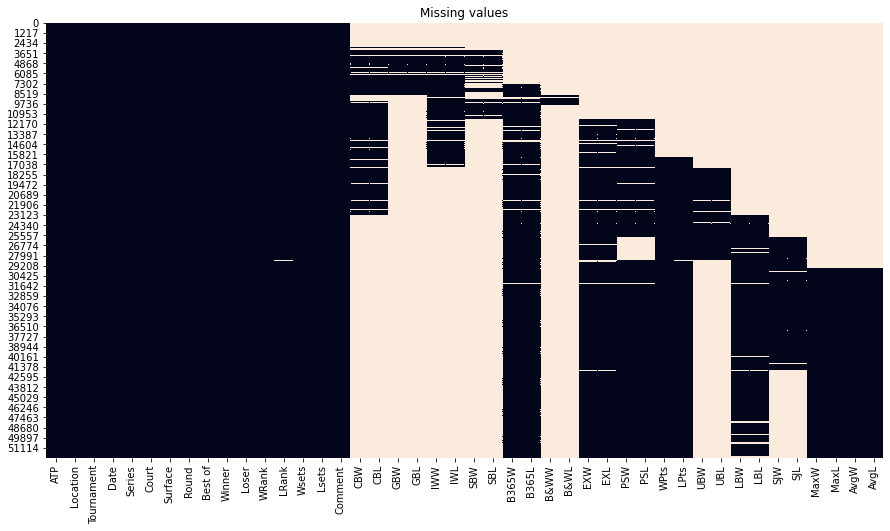

In [182]:
def show_missing_data_pattern(df):
    "Plot the missing data pattern in the dataframe."
    plt.subplots(figsize=(15,8));
    sns.heatmap(df_atp.isnull(),cbar=False);
    plt.title("Missing values")
    plt.show()

show_missing_data_pattern(df_atp)

**Note**: Many values are missing from multiple columns. Let's compute the exact rate of missing rows per feature and display it.  


In [183]:
def missing_rows_rate(df): return round(df.isna().sum()/len(df),4)

def show_missing_rows_rate(df):
    "Show the percentage of missing rows in the columns of the dataframe."
    missing_rate = missing_rows_rate(df).to_frame().T # Conversion and transposition for an aesthetic purpose.
    for i,j in zip(range(0,34,11), range(11,45,11)):
        print(missing_rate[[columns for columns in missing_rate.columns[i:j]]].to_string(index=False))
        print("----------------------------------------------------------------------------------------")
        
show_missing_rows_rate(df_atp)

 ATP  Location  Tournament  Date  Series  Court  Surface  Round  Best of  Winner  Loser
 0.0       0.0         0.0   0.0     0.0    0.0      0.0    0.0      0.0     0.0    0.0
----------------------------------------------------------------------------------------
  WRank   LRank   Wsets   Lsets  Comment     CBW     CBL     GBW     GBL     IWW     IWL
 0.0003  0.0015  0.0043  0.0043      0.0  0.6653  0.6653  0.9033  0.9033  0.7446  0.7446
----------------------------------------------------------------------------------------
    SBW     SBL   B365W   B365L   B&WW   B&WL     EXW     EXL    PSW    PSL    WPts
 0.8963  0.8963  0.1655  0.1651  0.979  0.979  0.2464  0.2463  0.286  0.286  0.3098
----------------------------------------------------------------------------------------
  LPts    UBW    UBL     LBW     LBL     SJW     SJL    MaxW    MaxL    AvgW    AvgL
 0.311  0.796  0.796  0.4621  0.4619  0.7022  0.7021  0.5651  0.5651  0.5651  0.5651
-----------------------------------------

**Conclusions**:
As noticed some features are unsuitable due to the high rate of missing rows. After carefully analysing the above results, I decided:
        
- For the bookmakers odds, to keep only Pinnacle, Expekt and Bet365 as they contain the lowest rate of missing values.       
- Remove WPts and LPts, as one third of the rows is missing. 

(**Note**: According to [Clarke, 1994](https://researchbank.swinburne.edu.au/file/68062d69-4417-4604-a780-4e0766353eca/1/PDF%20%289%20p%29.pdf), ATP ratings and points do not accurately reflect a player’s form.)

In [184]:
df_atp = df_atp.drop(['WPts','LPts','CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL', 'SBW', 'SBL',
                      'B&WW', 'B&WL', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW', 
                      'MaxL','AvgW', 'AvgL'],axis = 1 )

<a name='2-4'></a>
### 2.4. Questions

**1. Who are the three ATP players with the most wins ?**

In [185]:
print(df_atp['Winner'].value_counts()[:3].to_string())

federer r.     1125
nadal r.        891
djokovic n.     807


**Remark** : To address the remaining questions, I defined `collect_information`a function that adds two new features to the dataframe: P1_history and P2_history representing the percentage of victories in the past for the first player(Winner) and the second player(Loser), respectively. This function also returns a dictionary containing useful information about the players.

**Notes**: 
1. As stated in section 2.1.2, I will now remove the rows corresponding to a win by walkover.
2. For a single level of nesting, the `defaultdict` can be used directly.


In [186]:
df_atp = df_atp[df_atp['Comment']!='Walkover']

In [187]:
def initialize(df):
    """Return an initialisation of a nested dictionary containing information about the players.
    {'Players_name':{'games_won':0,'sets_won':0,'total_games':0}, ...}"""
    names = players_names(df)
    initialized_dictionary = {name: {'games_won':0, 'sets_won':0, 'total_games':0} for name in names}
    return initialized_dictionary

def collect_information(df):
    """Return a nested dictionary containing information about all the players in the input dataframe.
    Add two new features representing each the percentage of victories in the past of the first player 
    and the second player (P1_history, P2_history)."""    
    information = initialize(df)
    df['P1_history'] = 0.0
    df['P2_history'] = 0.0    
    for i in range(len(df)):
        first_player = df.Winner.iloc[i]
        second_player = df.Loser.iloc[i] 
        first_player_first_game = information[first_player]['total_games'] == 0
        second_player_first_game = information[second_player]['total_games'] == 0        
        if first_player_first_game: 
            df.P1_history.iloc[i] = 0.0
        if second_player_first_game:
            df.P2_history.iloc[i] = 0.0
        if not first_player_first_game :        
            df.P1_history.iloc[i] = round(information[first_player]['games_won']/information[first_player]['total_games'],3)
        if not second_player_first_game :          
            df.P2_history.iloc[i] = round( information[second_player]['games_won']/information[second_player]['total_games'],3)           
        # Updating the information dictionary.   
        information[first_player]['total_games'] += 1
        information[second_player]['total_games'] += 1
        information[first_player]['games_won'] += 1
        information[first_player]['sets_won'] += df.Wsets.iloc[i]
        information[second_player]['sets_won'] += df.Lsets.iloc[i]
        information[first_player]['total_games'] += 1
    return information


**2. How many sets did the player “ Federer R.” win in total ?**

In [188]:
df_copy = df_atp.copy(deep=True)
complete_information = collect_information(df_copy)
print(int(complete_information['federer r.']['sets_won']))

2705


**3. How many sets did the player “ Federer R.” win during the years 2016 and 2017 ?**

In [189]:
df_partial = df_copy[(df_copy.Date>=datetime.datetime(2016,1,1))&(df_copy.Date<datetime.datetime(2018,1,1))].copy(deep=True)
partial_information = collect_information(df_partial)
print(int(partial_information['federer r.']['sets_won']))

182


**4. For each match, what is the percentage of victories of the winner in the past ?**

The percentage of victories of the winners in the past is the new column P1_history in df_copy. 

In [191]:
print(df_copy.P1_history.to_string());

0        0.000
1        0.000
2        0.000
3        0.000
4        0.000
5        0.000
6        0.000
7        0.000
8        0.000
9        0.000
10       0.000
11       0.000
12       0.000
13       0.000
14       0.000
15       0.000
16       0.500
17       0.500
18       0.500
19       0.500
20       0.500
21       0.500
22       0.500
23       0.500
24       0.500
25       0.500
26       0.500
27       0.500
28       0.500
29       0.500
30       0.500
31       0.000
32       0.000
33       0.000
34       0.000
35       0.000
36       0.000
37       0.000
38       0.000
39       0.000
40       0.000
41       0.000
42       0.000
43       0.000
44       0.000
45       0.000
46       0.000
47       0.500
48       0.500
49       0.500
50       0.500
51       0.500
52       0.500
53       0.500
54       0.500
55       0.500
56       0.500
57       0.500
58       0.500
59       0.500
60       0.500
61       0.500
62       0.000
63       0.000
64       0.000
65       0.000
66       0

A glimpse of what it looks like in the dataframe:


In [192]:
df_copy[["Winner","Loser","P1_history"]].iloc[5000:5010]

,Winner,Loser,P1_history
5018,mirnyi m.,niemeyer f.,0.325
5019,moya c.,rusedski g.,0.386
5020,norman m.,ilie a.,0.408
5021,pavel a.,malisse x.,0.345
5022,rafter p.,levy h.,0.406
5023,roddick a.,lee h.t.,0.397
5024,santoro f.,portas a.,0.361
5025,ulihrach b.,lee m.,0.351
5026,vicente f.,squillari f.,0.302
5027,vinciguerra a.,ferreira w.,0.357


<a name='2-5'></a>
### 2.5. Feature extraction

In this section we will combine some existing features to produce a more useful ones.  

<a name='2-5-1'></a>
#### 2.5.1. The percentage of victories of the player in the past

At the moment, we already have two new extracted features. In section 2.4, I implemented `collect_information` a function that adds the percentage of victories in the past of both the two players to the dataframe. The two features  `P1_history` and `P2_history`  estimate to some degree the performance of the players.

<a name='2-5-2'></a>
#### 2.5.2. Head to head balance

Some players regularly face difficulties against a particular player despite being the favourite.

In this case, in order to lower our predicted probability for the favourite player to win. I will use the head to head balance proposed by [Spiko, 2015, Head-to-head balance section](https://www.doc.ic.ac.uk/teaching/distinguished-projects/2015/m.sipko.pdf). <br>
This method consists of computing the percentage of the victories of the players in the past, this time not for all the games, but only for the games opposing the two players. 

**Note**: The `head_to_head` function defined below does exactly that, but it doesn't only add the two head to head balance statistics for the two players pre-game. It also adds these statistics post-game. These post-game statistics will evidently `not be used` for the prediction, I only use them to compute the common opponents method introduced in the next section. 

In [193]:
def encounters_identifier(df) :
    """Return a dictionary containing all the ecounters and assigns an identifier to each one of them.
    {'(first_player,second_player)':identifier ...}"""
    identifier = 0
    identified_encounters = {}
    df["Id"] = 0
    for i in range(len(df)):
        first_player = df.Winner.iloc[i]
        second_player = df.Loser.iloc[i]
        direct_encounter_has_id = (first_player,second_player) in identified_encounters
        inversed_encounter_has_id = (second_player,first_player) in identified_encounters
        encounter_has_no_id = (not direct_encounter_has_id) and (not inversed_encounter_has_id)        
        if encounter_has_no_id :
            identified_encounters[(first_player,second_player)]= identifier
            identifier += 1          
        if  (first_player,second_player) in identified_encounters  :
            df.Id.iloc[i] = identified_encounters[(first_player,second_player)]
        if  (second_player,first_player) in identified_encounters :
            df.Id.iloc[i] = identified_encounters[(second_player,first_player)]
    return identified_encounters

def initialize_encounters(df):
    """Return the initialized encounters dictionary.
    {'(first_player,second_player)':{'first_player':0,'second_player':0,'total_encounters':0}, ...}"""
    identified_encounters = encounters_identifier(df)
    encounters = {identified_encounters[encounter]:{encounter[0]:0,encounter[1]:0,'total_encouters':0}
                 for encounter in identified_encounters}
    return encounters

def initialize_head_to_head(df):
    "Initialize the head to head columns."
    df['P1_prematch_hth'] = 0.0
    df['P2_prematch_hth'] = 0.0
    df['P1_postmatch_hth'] = 0.0
    df['P2_postmatch_hth'] = 0.0

def head_to_head(df):
    "Add four statistics to the dataframe, pre-game and post-game head to head statistics."
    initialize_head_to_head(df)
    prematch = initialize_encounters(df)
    postmatch = initialize_encounters(df)
    for i in range(len(df)) :
        first_player = df.Winner.iloc[i]
        second_player = df.Loser.iloc[i]
        postmatch[df.Id.iloc[i]]['total_encouters'] += 1
        postmatch[df.Id.iloc[i]][first_player] += 1
        total_encounters = postmatch[df.Id.iloc[i]]['total_encouters'] # Post-match information
        encounters_won_by_first_player = postmatch[df.Id.iloc[i]][first_player] # Post-match information
        encounters_won_by_second_player = postmatch[df.Id.iloc[i]][second_player] # Post-match information        
        df['P1_postmatch_hth'].iloc[i] = round(encounters_won_by_first_player/total_encounters,3)
        df['P2_postmatch_hth'].iloc[i] = round(encounters_won_by_second_player/total_encounters ,3)
        first_game = prematch[df.Id.iloc[i]]['total_encouters'] == 0
        if first_game :
            df['P1_prematch_hth'].iloc[i] = 0
            df['P2_prematch_hth'].iloc[i] = 0
        else :
            total_encounters = prematch[df.Id.iloc[i]]['total_encouters'] # Pre-match information
            encounters_won_by_first_player = prematch[df.Id.iloc[i]][first_player] # Pre-match information
            encounters_won_by_second_player = prematch[df.Id.iloc[i]][second_player] # Pre-match information
            df['P1_prematch_hth'].iloc[i] = round(encounters_won_by_first_player/total_encounters,3)
            df['P2_prematch_hth'].iloc[i] = round(encounters_won_by_second_player/total_encounters,3)
        prematch[df.Id.iloc[i]]['total_encouters'] += 1
        prematch[df.Id.iloc[i]][first_player] += 1

**A glimpse of what it looks like**: 

In [194]:
df_head_to_head = df_atp.copy(deep=True)
head_to_head(df_head_to_head)
df_head_to_head[["Winner","Loser","P1_prematch_hth","P2_prematch_hth","P1_postmatch_hth","P2_postmatch_hth"]][df_head_to_head.Id== 7757] 

,Winner,Loser,P1_prematch_hth,P2_prematch_hth,P1_postmatch_hth,P2_postmatch_hth
11277,robredo t.,melzer j.,0.000,0.000,1.000,0.000
11412,melzer j.,robredo t.,0.000,1.000,0.500,0.500
14486,melzer j.,robredo t.,0.500,0.500,0.667,0.333
17430,robredo t.,melzer j.,0.333,0.667,0.500,0.500
19352,melzer j.,robredo t.,0.500,0.500,0.600,0.400
20569,robredo t.,melzer j.,0.400,0.600,0.500,0.500
25969,robredo t.,melzer j.,0.500,0.500,0.571,0.429
29208,melzer j.,robredo t.,0.429,0.571,0.500,0.500


<a name='2-5-3'></a>
#### 2.5.3. Common opponents

The extraction of `P1_history` and `P2_history` is simple but is `limited`. If for instance Player 1 had more difficult opponents than Player 2, the result will be biased towards Player 2.

To lower this bias, I will compare the players by using their common opponents. This method was inspired from the common opponents comparison of the serve and return winning percentages in the Markov model proposed by [Knottenbelt et al., 2012](https://core.ac.uk/download/pdf/82518495.pdf).

For every game, the method consists of averaging the head to head balance statistics of all the opponents they had in common before the game.

Per example, if the players below had three common opponents before their encounter. Let  $w_{1i}$ and $w_{2i}$  be their head to head balance statistics. 

<table>
<tr><th>Common<br>opponents<th>Player 1<th>Player 2
<tr><td>Common_1<td>$w_{11}$<td>$w_{21}$
<tr><td>Common_2<td>$w_{12}$<td>$w_{22}$
<tr><td>Common_3<td>$w_{13}$<td>$w_{23}$
    
</table>
<br>
<br>
The common opponents statistic for Player 1 is then &emsp; $\frac{w_{11}+w_{12}+w_{13}}{3}$&emsp; and  &emsp;$\frac{w_{21}+w_{22}+w_{23}}{3}$ &emsp;for Player 2. 


    
    
**Note**: The `common_opponents` function defined below adds the two common opponents statistics for the two players. These statistics are pre-game statistics, even if they use the head to head balance post-game statistics for the common opponents (`the encounters with the common opponents are always in the past.`)

In [195]:
def initialize_common_opponents(df):
    """Initialize the common opponents statistics columns.
    Return the initialized opponents dictionary. {'player':{}, ...}"""    
    df["P1_common_opponents"] = 0
    df["P2_common_opponents"] = 0    
    players = players_names(df)
    opponents = {player:{} for player in players}
    return opponents

def common_opponents(df):
    "Add the common opponents statistics of the first and second player to the dataframe."
    opponents = initialize_common_opponents(df)
    for i in range(len(df)) :
        first_player = df.Winner.iloc[i]
        second_player = df.Loser.iloc[i]
        opponents[first_player][second_player] = df.P1_postmatch_hth.iloc[i]
        opponents[second_player][first_player] = df.P2_postmatch_hth.iloc[i]        
        first_player_opponents= frozenset(opponents[first_player].keys())
        second_player_opponents= frozenset(opponents[second_player].keys()) 
        common_opponents = first_player_opponents.intersection(second_player_opponents)	
        if common_opponents != frozenset() :
            first_player_performance = [opponents[first_player][player] for player in common_opponents]
            second_player_performance = [opponents[second_player][player] for player in common_opponents]
            df.P1_common_opponents.iloc[i] = round(sum(first_player_performance)/len(first_player_performance),3) 
            df.P2_common_opponents.iloc[i] = round(sum(second_player_performance)/len(second_player_performance),3)

**A glimpse of what it looks like**: 

In [196]:
common_opponents(df_head_to_head)
df_head_to_head[["Winner","Loser","P1_common_opponents","P2_common_opponents"]][df_head_to_head.Id== 7757]

,Winner,Loser,P1_common_opponents,P2_common_opponents
11277,robredo t.,melzer j.,0.535,0.375
11412,melzer j.,robredo t.,0.375,0.535
14486,melzer j.,robredo t.,0.500,0.606
17430,robredo t.,melzer j.,0.594,0.460
19352,melzer j.,robredo t.,0.466,0.611
20569,robredo t.,melzer j.,0.630,0.489
25969,robredo t.,melzer j.,0.644,0.481
29208,melzer j.,robredo t.,0.525,0.653


<a name='2-6'></a>
### 2.6. The target attribute 

The objective of this project is to predict the outcome of an ATP tennis game, given two players and some pre-match information. 

We define the target value as follows :
$\begin{equation}
  y = \left \{
  \begin{aligned}
    &1, && \text{if}\ \text{Player 1 won} \\
    &0, && \text{if}\ \text{Player 1 lost}
  \end{aligned} \right.
\end{equation} 
$


(**Note**: In the ATP dataset the target value is then always 0 or 1 for all the rows. Per example if we choose the column Winner to be the Player 1 column, then the target value is always 1. In this project, I choose Player 1 to be the winner.)

In [197]:
def target(df): 
    "Add the target attribute to our dataframe."
    df['label'] = 1

<a name='2-7'></a>
### 2.7. Odds imputation

The odds of the bookmakers are a valuable information. According to [Kaunitz et al., 2017](https://arxiv.org/ftp/arxiv/papers/1710/1710.02824.pdf), the mean closing odds across bookmakers is a precise estimate of the true probability of the occurrence of an event. Knowing that it's their expertise, the bookmakers models are very accurate.

To make the most of the odds, I defined below the function `odds_imputer` that does the following: 
- For an observation, if a bookmarker's odds are missing, it's impute them to the other available bookmaker's odds.

**Notes**: 
1. For a game the odds across bookmakers are usually very close.
2. We will train our model with the observations that contain at least one bookmaker's odds.   
3. The number of observations with no bookmaker's odds in the year for which we want to predict the outcome of the tennis matches (2017), is very small, I will impute these few observation's odds to 1 and impute the rest with `odds_imputer`.

<br><br>
The number of observations with no bookmaker's odds in the year 2017 is 6: 

In [198]:
df_head_to_head[(df_head_to_head.Date>=datetime.datetime(2017,1,1))&(df_head_to_head.Date<datetime.datetime(2018,1,1))][(df_head_to_head.PSW.isna())&(df_head_to_head.B365W.isna())][[c for c in df_head_to_head.columns[9:22]]]

,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,B365W,B365L,EXW,EXL,PSW,PSL
47413,kukushkin m.,becker b.,103.0,139.0,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN
47865,vesely j.,vanni l.,53.0,122.0,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN
47898,haase r.,dzumhur d.,46.0,92.0,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN
48478,chardy j.,broady l.,80.0,404.0,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN
48683,olivo r.,mathieu p.h.,119.0,166.0,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN
48964,escobedo e.,basilashvili n.,85.0,63.0,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN


**Odds_imputer**:

In [199]:
def odds_imputer(dataframe):
    "For the observations with a missing bookmaker's odds, it's impute these odds to the available ones."
    df = dataframe.copy(deep=True)
    df = df.reset_index(drop=True)
    missing_B365 =   df[df.B365W.isna() & (df.PSW.notna() | df.EXW.notna()) ].index 
    missing_pinnacle = df[df.PSW.isna() & (df.B365W.notna() | df.EXW.notna()) ].index  
    missing_expekt = df[df.EXW.isna() & (df.B365W.notna() | df.PSW.notna()) ].index 
    bet365_notna = df.B365W.notna()
    expket_notna = df.EXW.notna()
    pinnacle_notna = df.PSW.notna() 
    for index in missing_B365 : 
        Pinnacle_not_missing = pinnacle_notna.iloc[index]
        if Pinnacle_not_missing :  # A preference for Pinnacle odds. 
            df.B365W.iloc[index] = df.PSW.iloc[index]
            df.B365L.iloc[index] = df.PSL.iloc[index]
        if not Pinnacle_not_missing :
            df.B365W.iloc[index] = df.EXW.iloc[index]
            df.B365L.iloc[index] = df.EXL.iloc[index]                
    for index in missing_pinnacle : 
        expekt_not_missing = expket_notna.iloc[index]
        if expekt_not_missing : 
            df.PSW.iloc[index] = df.EXW.iloc[index] # A preference for Expekt odds.
            df.PSL.iloc[index] = df.EXL.iloc[index]
        if not expekt_not_missing :
            df.PSW.iloc[index] = df.B365W.iloc[index]
            df.PSL.iloc[index] = df.B365L.iloc[index]
    for i in missing_expekt : 
        Pinnacle_not_missing = pinnacle_notna.iloc[i]
        if Pinnacle_not_missing : 
            df.EXW.iloc[i] = df.PSW.iloc[i]  # A preference for Pinnacle odds. 
            df.EXL.iloc[i] = df.PSL.iloc[i]
        if not Pinnacle_not_missing :
            df.EXW.iloc[i] = df.B365W.iloc[i]
            df.EXL.iloc[i] = df.B365L.iloc[i]        
    return df

<a name='2-8'></a>
### 2.8. Categorical variables

Some of the categorical features in the dataframe are very valuable, thus we will need to turn them into one hot features
to use them for our model.   

According to [Barnett et al., 2007](https://strategicgames.com.au/article7.pdf), the players performances are affected by the court surface. Players that perform best on the faster surfaces can be considered to be disadvantaged on the tour, due to the lack of grass court tournaments available. 

For this reason I decided to turn into one hot features the following categorical variables : Surface, court and round. 
To accomplish this I defined the function `to_one_hot` below. 

In [200]:
def to_one_hot(df, columns):
    "Convert the input columns to one hot features in the dataframe."
    one_hot_df = df
    for column in columns : 
        one_hot_df = pd.concat([one_hot_df.drop(column, axis=1), pd.get_dummies(df[column],prefix=column, drop_first= True)], axis=1)
    return one_hot_df

<a name='3'></a>
## 3. The modeling phase

<a name='3-1'></a>
### 3.1. Splitting the data set

I'll split the data set in the following way:
- Training set:  from the year 2000 to 2014 (14 years) 
- Validation set: from 2015  to 2016 (2 years)
- Test set: the year 2017

For this purpose, I define the function `splitting_dataframe` below.

In [201]:
def splitting_dataframe(df, start_year, end_year):
    "Return the dataframe with the date column starting and ending at the input years."
    start_year = datetime.datetime(start_year,1,1) # Converting input to datetime type. 
    end_year = datetime.datetime(end_year,1,1)
    desired_dataframe = df[(df.Date>=start_year)&(df.Date<end_year)]
    return desired_dataframe

<a name='3-2'></a>
### 3.2. Pipelines

I will define the function `process(df)` that applies all the features extraction functions as well as the preprocessing functions defined before. The input dataframe needs to be noiseless. 

**Notes**: 
* Tennis matches follow a chronological order (a player cannot be present at two matches at the same time). For a match in the test set, we can use all the matches that preceded it in order to collect pre-match information.

* Although it is strongly discouraged to process the data set before splitting it to a train and test set. The operations we perform below do not introduce any `target leakage`, since the odds imputation is not a mean or an iterative imputation. 

In [202]:
def process(df):
    """Return a processed dataframe with all the extracted features. 
    The input dataframe needs to be noiseless."""
    collect_information(df) #The creation of P1_history and P2_history
    head_to_head(df) #The creation of Pi_postmatch_hth and Pi_prematch_hth, i=1..2
    common_opponents(df) #The creation of P1_common_opponents and P2_common_opponents
    df = df.drop(['P1_postmatch_hth','P2_postmatch_hth'],axis=1) # We make sure to delete the post match information.
    target(df)
    df_imputed = odds_imputer(df) # It doesn't drop the odds.
    return df_imputed
df_processed = process(df_atp)
df_processed = to_one_hot(df_processed, ['Surface','Court','Round'])

**Handling the imbalanced dataset**

We can't train our model directly on the dataframe, due to the imbalance of the label.<br>
In order to solve this problem, I define below the `balance` function, to balance our training data by inverting the loser and winner related columns for some observations (randomly chosen) and assigns their label to 0.

In [203]:
def balance(df) :    
    "Return a balanced dataframe."
    random_binary_list = list(np.random.randint(2, size= len(df))) # example: [0,1,0,0,1,..]
    indices_to_balance = []
    indices = list(df.index)
    for (i,boolean) in enumerate(random_binary_list) : 
        if boolean : 
            indices_to_balance.append(indices[i])    
    for item in indices_to_balance : 
        indices.remove(item)
    df_winners = df.copy(deep=True).loc[indices]
    df_losers = df.copy(deep=True).loc[indices_to_balance]
    df_winners['label'] = 1
    df_losers['label'] = 0
    df_losers.B365L, df_losers.B365W = df.loc[indices_to_balance].B365W, df.loc[indices_to_balance].B365L
    df_losers.PSL, df_losers.PSW = df.loc[indices_to_balance].PSW, df.loc[indices_to_balance].PSL
    df_losers.EXL, df_losers.EXW = df.loc[indices_to_balance].EXW, df.loc[indices_to_balance].EXL
    df_losers.Winner, df_losers.Loser = df.loc[indices_to_balance].Loser, df.loc[indices_to_balance].Winner
    df_losers.LRank, df_losers.WRank = df.loc[indices_to_balance].WRank, df.loc[indices_to_balance].LRank
    df_losers.P1_common_opponents, df_losers.P2_common_opponents = df.loc[indices_to_balance].P2_common_opponents, df.loc[indices_to_balance].P1_common_opponents
    df_losers.P1_prematch_hth, df_losers.P2_prematch_hth = df.loc[indices_to_balance].P2_prematch_hth , df.loc[indices_to_balance].P1_prematch_hth
    df_losers.P1_history, df_losers.P2_history = df.loc[indices_to_balance].P2_history, df.loc[indices_to_balance].P1_history
    df = pd.concat([df_winners,df_losers],join='inner').sample(frac = 1)    # The shuffling is optional.
    return df


**The split pipeline**:

In [204]:
def process_test(df):
    """Impute the odds of the observations for which all the bookmakers odds are missing to 1.
    Impute the non ranked players to the rank 2000.
    Return a dataframe with the mentioned imputations."""
    df_nona = df.copy(deep=True)
    df_nona = df_nona.reset_index(drop=True)
    missing_odds = df_nona[(df_nona.PSW.isna())&(df_nona.B365W.isna())&(df_nona.EXW.isna())].index
    missing_rank = df_nona[(df_nona.LRank.isna())].index  
    for i in missing_odds :
        df_nona.B365W.iloc[i] = 1
        df_nona.B365L.iloc[i] = 1
        df_nona.PSW.iloc[i] = 1
        df_nona.PSL.iloc[i] = 1
        df_nona.EXW.iloc[i] = 1
        df_nona.EXL.iloc[i] = 1
    for i in missing_rank :
        df_nona.LRank.iloc[i] = 2000
    return df_nona

def split(df_processed) : 
    "split the dataframe to a training, validation and test sets."
    df_train = splitting_dataframe(df_processed, 2000,2015)
    df_validation = splitting_dataframe(df_processed, 2015,2017)
    df_test = splitting_dataframe(df_processed, 2017,2018)
    df_train = balance(df_train)
    df_train = df_train.drop(['ATP', 'Location', 'Tournament', 'Date','Series','Winner',
                            'Loser','Wsets', 'Lsets', 'Comment','Id'],axis =1)
    df_validation = df_validation.drop(['ATP', 'Location', 'Tournament', 'Date','Series','Winner',
                            'Loser','Wsets', 'Lsets', 'Comment','Id'],axis =1)
    df_test = df_test.drop(['ATP', 'Location', 'Tournament', 'Date','Series','Winner',
                            'Loser','Wsets', 'Lsets', 'Comment','Id'],axis =1)
    df_train = df_train.dropna()
    df_validation = df_validation.dropna()
    df_test = process_test(df_test)
    x_train, y_train = df_train.drop(['label'],axis=1), df_train['label']
    x_val, y_val = df_validation.drop(['label'],axis=1), df_validation['label']
    x_test, y_test = df_test.drop(['label'],axis=1), df_test['label']
    return (x_train,y_train),(x_val,y_val),(x_test,y_test)
    

In [205]:
(x_train,y_train),(x_val,y_val),(x_test,y_test) = split(df_processed)

**The training set is now well balanced**: 

In [206]:
y_train.sum()/len(y_train)

0.4999850106424439

<a name='3-3'></a>
### 3.3. Models

<a name='3-3-1'></a>
#### 3.3.1.  An intuitive model

If we don't intend to make any bets and the goal is simply to predict the outcome of the tennis matches. Then 
an intuitive simple model but very accurate is to use directly one of the bookmakers odds. 

In [35]:
def intuitive_model(x_test):
    "Return the predictions for the outcome of the input tennis matches."
    y_predicted = np.ones(len(x_test))
    for i in range(len(x_test)):
        if x_test.PSW.iloc[i] <= x_test.PSL.iloc[i]:
            y_predicted[i]= 1
        else : 
            y_predicted[i] = 0
    return y_predicted

y_predicted = intuitive_model(x_test)
print(accuracy_score(y_predicted,y_test))

0.6882869133918352


**Comment** : For predicting the outcome of matches in the year 2017, the model using Pinnacle odds has an accuracy of nearly 69%.

<a name='3-3-2'></a>
#### 3.3.2 Artificial neural networks

Several papers obtained good results using neural networks to predict the outcome of tennis matches.
* [Somboonphokkaphan et al., 2009](http://www.iaeng.org/publication/IMECS2009/IMECS2009_pp127-132.pdf) used a three Layer
MLP with back-propagation learning. 
* [Spiko, 2015](https://www.doc.ic.ac.uk/teaching/distinguished-projects/2015/m.sipko.pdf) used a neural network with one single hidden layer.

We implement it ourselves to see if we obtain a good result for the accuracy of our predictions. 

**A first attempt**

In [37]:
first_attempt = keras.Sequential([
                layers.Dense(64,input_shape=(26,), activation='relu'),
                layers.Dense(64, activation='tanh'),
                layers.Dense(1,activation='sigmoid')])
first_attempt.compile(
optimizer=tf.keras.optimizers.Adam(),
                loss = 'binary_crossentropy',
                metrics=['accuracy'])
first_attempt.build() 
first_attempt.fit(x_train, y_train,validation_data=(x_val,y_val),epochs=20,verbose=1)

Epoch 1/20
1043/1043 [==============================] - 1s 1ms/step - loss: 0.6071 - accuracy: 0.6664 - val_loss: 0.6522 - val_accuracy: 0.5903
Epoch 2/20
1043/1043 [==============================] - 1s 1ms/step - loss: 0.5882 - accuracy: 0.6850 - val_loss: 0.5790 - val_accuracy: 0.6882
Epoch 3/20
1043/1043 [==============================] - 1s 1ms/step - loss: 0.5825 - accuracy: 0.6886 - val_loss: 0.6325 - val_accuracy: 0.6164
Epoch 4/20
1043/1043 [==============================] - 1s 1ms/step - loss: 0.5803 - accuracy: 0.6912 - val_loss: 0.5066 - val_accuracy: 0.7169
Epoch 5/20
1043/1043 [==============================] - 1s 1ms/step - loss: 0.5786 - accuracy: 0.6944 - val_loss: 0.6257 - val_accuracy: 0.6418
Epoch 6/20
1043/1043 [==============================] - 1s 1ms/step - loss: 0.5768 - accuracy: 0.6971 - val_loss: 0.5516 - val_accuracy: 0.7201
Epoch 7/20
1043/1043 [==============================] - 1s 1ms/step - loss: 0.5760 - accuracy: 0.6960 - val_loss: 0.6049 - val_accuracy:

**Comment**: In a first attempt of fitting the training set with no hyperparameters tunning, we obtained an accuracy of 68%. The same as the intuitive model defined below. 

In [38]:
first_attempt.evaluate(x_test, y_test, verbose=2)

82/82 - 0s - loss: 0.5927 - accuracy: 0.6829


[0.5927402377128601, 0.6829454302787781]

**Expanding the data**

It is common knowledge that a smaller training data set results in a weaker approximation.
For this reason we will use the data provided by The Women's Tennis Association `(WTA)` in order to expand our training data. 

**Note**: The transformations that will be applied to `df_wta` have all been detailed when applied to df_atp earlier in the project.

In [40]:
show_noise(df_wta)

Arruabarrena Vecino L.  ||  Arruabarrena-Vecino L.
Cabeza Candela E.  ||  Cabeza-Candela E.
Chan C-W.  ||  Chan C.W.
Duque Marino M.  ||  Duque-Marino M.
Garcia Vidagany B.  ||  Garcia-Vidagany B.
Han N-L.  ||  Han N.L.
Han S-H.  ||  Han S.H.
Kim S-J.  ||  Kim S.J.
Lee Y-H.  ||  Lee Y.H.
Lu Jia Jing  ||  Lu Jia-Jing
Lu Jing Jing  ||  Lu Jing-Jing
O'Brien K.  ||  O'brien K.
Solovieva V.  ||  Solovyeva V.
Torro Flor M.T.  ||  Torro-Flor M.T.
Wang Xiy.  ||  Wang Xiyu
Xu Y-F.  ||  Xu Y.F.
Zhang K-L.  ||  Zhang K.L.


In [41]:
df_wta = remove_noise(df_wta)
show_noise(df_wta)

badosa gibert p.  ||  badosa gibert.p.
chan c w.  ||  chan c.w.
han n l.  ||  han n.l.
han s h.  ||  han s.h.
kim s j.  ||  kim s.j.
lee y h.  ||  lee y.h.
pous t l.  ||  pous t.l.
solovieva v.  ||  solovyeva v.
xu y f.  ||  xu y.f.
zhang k l.  ||  zhang k.l.


In [42]:
wanted_corrections = {'badosa gibert p.':'badosa gibert.p.', 'chan c w.':'chan c.w.', 
                      'han n l.':'han n.l.', 'han s h.':'han s.h.', 'kim s j.':'kim s.j.',
                     'lee y h.':'lee y.h.','pous t l.':'pous t.l.','solovieva v.':'solovyeva v.',
                     'xu y f.':'xu y.f.','zhang k l.':'zhang k.l.'}
df_wta = rectify_names(df_wta, wanted_corrections)

C:\Users\Aiman\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [43]:
def patch_up_wta(df):
    "Remove noise from the pertinent features."
    df.EXW = df.EXW.replace(" ",np.nan)
    df.EXW = df.EXW.astype(float)
    df.B365L = df.EXW.replace("5..5",5.5)
    df.B365L = df.B365L.astype(float)
patch_up_wta(df_wta)
show_missing_rows_rate(df_wta)

 WTA  Location  Tournament    Date  Tier  Court  Surface  Round  Best of  Winner  Loser
 0.0       0.0         0.0  0.0001   0.0    0.0      0.0    0.0      0.0     0.0    0.0
----------------------------------------------------------------------------------------
  WRank   LRank    WPts    LPts      W1      L1      W2      L2     W3     L3   Wsets
 0.0013  0.0027  0.0013  0.0027  0.0059  0.0059  0.0159  0.0159  0.684  0.684  0.0059
----------------------------------------------------------------------------------------
  Lsets  Comment  B365W   B365L     CBW     CBL     EXW     EXL    PSW    PSL    UBW
 0.0059      0.0  0.008  0.0253  0.9179  0.9179  0.0253  0.0253  0.091  0.091  0.766
----------------------------------------------------------------------------------------
   UBL    LBW    LBL    SJW    SJL    MaxW    MaxL    AvgW    AvgL
 0.766  0.114  0.114  0.522  0.522  0.2781  0.2781  0.2781  0.2781
---------------------------------------------------------------------------------

The only differences in the processing function of df_wta are:
* We take only the observations from 2000 and 2014, the data expansion will then only affect the training set. 
* We remove the matches with Greenset as the surfaces since this surface does not exist in the ATP data frame.

In [44]:
def process_wta(df_wta):
    "Return the WTA dataframe processed"
    df = df_wta.copy(deep=True)
    df = df.drop(['W1', 'L1','W2', 'L2', 'W3', 'L3', 'WPts','LPts','CBW', 
                      'CBL','WPts','LPts','MaxW', 'MaxL','AvgW', 'AvgL','SJW',
                      'SJL','UBW', 'UBL', 'LBW', 'LBL'],axis = 1 )
    df = df[df['Comment']!='Walkover']
    df = df[df['Surface']!='Greenset'] #Explain
    df = splitting_dataframe(df,2000,2014)
    df_processed = process(df)
    return df_processed
df_wta_processed = process_wta(df_wta)

C:\Users\Aiman\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [45]:
df_atp_processed = process(df_atp)

df_augmented = df_atp_processed.merge(df_wta_processed, on=['Date', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank',  'B365W', 'B365L', 'EXW', 'EXL', 'PSW', 'PSL',
       'P1_history','P2_history','P1_prematch_hth', 'P2_prematch_hth','P1_common_opponents',
       'P2_common_opponents', 'label','Id','Wsets','Lsets','Comment','Location','Tournament'], how = 'outer')
df_augmented = df_augmented.drop(['WTA', 'Tier'],axis=1)
df_augmented = df_augmented.sort_values(by='Date') 
df_augmented = to_one_hot(df_augmented, ['Surface','Court','Round'])

In [46]:
(x_augmented_train,y_augmented_train),(x_augmented_val,y_augmented_val),(x_augmented_test,y_augmented_test) = split(df_augmented)

C:\Users\Aiman\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


**Note**:
* y_augmented_test is the same as y_test.

In [47]:
(y_augmented_test.sum() == y_test.sum())&(len(x_augmented_test)==len(x_test))

True

**Normalizing Inputs**

To make the cost function look more symmetric and speed up the training, I'm normalizing the features.

**Note**: I'm using the training set's mean and standard deviation to normalize the validation and test set.

In [48]:
continuous_columns = ['Best of','WRank', 'LRank','B365W','B365L','EXW','EXL','PSW','PSL']
mean = x_augmented_train.loc[:, continuous_columns].mean()
std = x_augmented_train.loc[:, continuous_columns].std()
x_augmented_train.loc[:, continuous_columns] = (x_augmented_train.loc[:, continuous_columns] - mean) / std
x_augmented_val.loc[:, continuous_columns] = (x_augmented_val.loc[:, continuous_columns] - mean) / std
x_augmented_test.loc[:, continuous_columns] = (x_augmented_test.loc[:, continuous_columns] - mean) / std

For the atp data : 

In [49]:
continuous_columns = ['Best of','WRank', 'LRank','B365W','B365L','EXW','EXL','PSW','PSL']
mean = x_train.loc[:, continuous_columns].mean()
std = x_train.loc[:, continuous_columns].std()
x_train.loc[:, continuous_columns] = (x_train.loc[:, continuous_columns] - mean) / std
x_val.loc[:, continuous_columns] = (x_val.loc[:, continuous_columns] - mean) / std
x_test.loc[:, continuous_columns] = (x_test.loc[:, continuous_columns] - mean) / std

**Number of layers**

I carry out a grid search to optimize the hidden layers number and the activation function. 

In [59]:
def create_model(hidden_layers=0, activation = 'relu'):
    "Initialize the constructor."
    model = keras.Sequential()
    model.add(layers.Dense(64,input_shape=(27,),activation='tanh'))
    for i in range(int(hidden_layers)):
        model.add(layers.Dense(64, activation=activation))            
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=
     ['accuracy'])
    return model
my_classifier = KerasClassifier(build_fn=create_model, verbose=0)
epochs = [20]
hidden_layers1 = [0,1]
activation1 = ['relu','tanh']
hyperparameters = dict(hidden_layers=hidden_layers1, epochs=epochs, activation=activation1)
grid = GridSearchCV(estimator=my_classifier,param_grid = hyperparameters)
grid_result = grid.fit(x_augmented_train, y_augmented_train,validation_data=(x_augmented_val,y_augmented_val))
grid_result.best_params_

{'activation': 'tanh', 'epochs': 20, 'hidden_layers': 1}

**Number of units**

Another grid search to optimize the number of units per layer. 

In [61]:
def create_model(unit_1=64, unit_2=64):
    "Initialize the constructor."
    model = keras.Sequential()
    model.add(layers.Dense(unit_1,input_shape=(27,),activation='tanh'))
    model.add(layers.Dense(unit_2, activation='tanh'))            
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=
     ['accuracy'])
    return model
my_classifier = KerasClassifier(build_fn=create_model, verbose=0)
epochs = [20]
units_1 = [50,64,80,100]
units_2 = [50,64,80,100]
activation1 = ['relu','tanh']
hyperparameters = dict(unit_1=units_1, unit_2=units_2, epochs=epochs)
grid = GridSearchCV(estimator=my_classifier,param_grid = hyperparameters)
grid_result = grid.fit(x_augmented_train, y_augmented_train,validation_data=(x_augmented_val,y_augmented_val))
grid_result.best_params_

{'epochs': 20, 'unit_1': 64, 'unit_2': 100}

A grid search for the learning rate

**Note**: This is the only way I found to include the hyperparameter search in the project. I usually do it by testing multiple models but I clearly can't include all the models I tested it would be unreadable.

In [65]:
def create_model(lr=0.001):
    "Initialize the constructor."
    model = keras.Sequential()
    model.add(layers.Dense(64, input_shape=(27,),activation='tanh'))
    model.add(layers.Dense(100,activation='tanh'))            
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr), metrics=
     ['accuracy'])
    return model
my_classifier = KerasClassifier(build_fn=create_model, verbose=0)
epochs = [20]
learning_rates = [1e-4,1e-2,4e-4]
hyperparameters = dict(lr=learning_rates, epochs=epochs)
grid = GridSearchCV(estimator=my_classifier,param_grid = hyperparameters)
grid_result = grid.fit(x_augmented_train, y_augmented_train,validation_data=(x_augmented_val,y_augmented_val))
grid_result.best_params_

{'epochs': 20, 'lr': 0.001}

**The second attempt**

I train a neural network with the hyperparameters found in the searches conducted above, I also use batch normalization to address the vanishing/exploding gradients problem

In [71]:
second_attempt = keras.Sequential([
                layers.Dense(64,input_shape=(27,), activation='tanh'),
                layers.Dense(100, activation='tanh'),
                layers.BatchNormalization(),
                layers.Dense(1,activation='sigmoid')])
second_attempt.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'binary_crossentropy',
                metrics=['accuracy'])
second_attempt.build() 
history = second_attempt.fit(x_augmented_train, y_augmented_train,validation_data=(x_augmented_val,y_augmented_val),epochs=200,verbose=1)

Epoch 1/200
1553/1553 [==============================] - 3s 2ms/step - loss: 0.5304 - accuracy: 0.7251 - val_loss: 0.6186 - val_accuracy: 0.7038
Epoch 2/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4605 - accuracy: 0.7715 - val_loss: 0.5622 - val_accuracy: 0.7518
Epoch 3/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4390 - accuracy: 0.7780 - val_loss: 0.5520 - val_accuracy: 0.7443
Epoch 4/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4274 - accuracy: 0.7838 - val_loss: 0.5491 - val_accuracy: 0.7267
Epoch 5/200
1553/1553 [==============================] - 3s 2ms/step - loss: 0.4226 - accuracy: 0.7845 - val_loss: 0.5360 - val_accuracy: 0.7891
Epoch 6/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4198 - accuracy: 0.7852 - val_loss: 0.5819 - val_accuracy: 0.6750
Epoch 7/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4152 - accuracy: 0.7875 - val_loss: 0.5388 - val_ac

Epoch 57/200
1553/1553 [==============================] - 3s 2ms/step - loss: 0.3936 - accuracy: 0.7968 - val_loss: 0.6141 - val_accuracy: 0.6675
Epoch 58/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3946 - accuracy: 0.7986 - val_loss: 0.6303 - val_accuracy: 0.6746
Epoch 59/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3941 - accuracy: 0.7974 - val_loss: 0.5566 - val_accuracy: 0.7157
Epoch 60/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3932 - accuracy: 0.7987 - val_loss: 0.5972 - val_accuracy: 0.6996
Epoch 61/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3936 - accuracy: 0.7990 - val_loss: 0.5583 - val_accuracy: 0.7128
Epoch 62/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3933 - accuracy: 0.7985 - val_loss: 0.6233 - val_accuracy: 0.6975
Epoch 63/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3937 - accuracy: 0.7989 - val_loss: 0.5715 -

1553/1553 [==============================] - 2s 1ms/step - loss: 0.3823 - accuracy: 0.8075 - val_loss: 0.5848 - val_accuracy: 0.7059
Epoch 114/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3811 - accuracy: 0.8075 - val_loss: 0.5938 - val_accuracy: 0.7144
Epoch 115/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3812 - accuracy: 0.8086 - val_loss: 0.5693 - val_accuracy: 0.7094
Epoch 116/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3802 - accuracy: 0.8088 - val_loss: 0.5853 - val_accuracy: 0.7078
Epoch 117/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3809 - accuracy: 0.8079 - val_loss: 0.5920 - val_accuracy: 0.6900
Epoch 118/200
1553/1553 [==============================] - 2s 2ms/step - loss: 0.3825 - accuracy: 0.8081 - val_loss: 0.6341 - val_accuracy: 0.6623
Epoch 119/200
1553/1553 [==============================] - 3s 2ms/step - loss: 0.3805 - accuracy: 0.8096 - val_loss: 0.5815 - val_ac

Epoch 169/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3675 - accuracy: 0.8174 - val_loss: 0.5518 - val_accuracy: 0.7280
Epoch 170/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3680 - accuracy: 0.8169 - val_loss: 0.6486 - val_accuracy: 0.6932
Epoch 171/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3682 - accuracy: 0.8154 - val_loss: 0.6003 - val_accuracy: 0.7057
Epoch 172/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3670 - accuracy: 0.8187 - val_loss: 0.5832 - val_accuracy: 0.7053
Epoch 173/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3669 - accuracy: 0.8167 - val_loss: 0.5495 - val_accuracy: 0.7374
Epoch 174/200
1553/1553 [==============================] - 2s 2ms/step - loss: 0.3674 - accuracy: 0.8183 - val_loss: 0.5163 - val_accuracy: 0.7372
Epoch 175/200
1553/1553 [==============================] - 2s 1ms/step - loss: 0.3670 - accuracy: 0.8185 - val_loss: 0

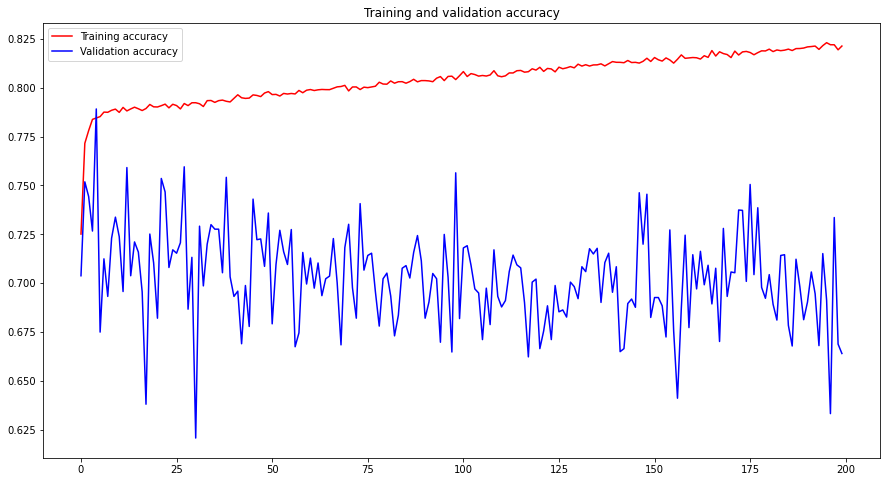

In [76]:
def plot_accuracy(history):
    "Plot the curves of the  training and validation accuracy."
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.subplots(figsize=(15,8));
    plt.plot(epochs, acc, 'r', label='Training accuracy');
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy');
    plt.title('Training and validation accuracy');
    plt.legend(loc=0);
    plt.show()
plot_accuracy(history)

In [73]:
second_attempt.evaluate(x_augmented_train, y_augmented_train, verbose=2)

1553/1553 - 1s - loss: 0.3471 - accuracy: 0.8288


[0.3471469581127167, 0.8287531733512878]

**Comment**: We get a very high accuracy, however by looking at the curves above, we see that the model does not generalize well. the obtained very high accuracy is a luck shot.

**Final attempt**

To reduce the variance in our model we use regularization to add extra terms that penalizes the weight matrices from being too large.

In [101]:
third_attempt = keras.Sequential([
                layers.Dense(64,input_shape=(27,), activation='tanh'),
                layers.BatchNormalization(),
                layers.Dense(100, activation='tanh',kernel_regularizer=tf.keras.regularizers.L2(
                l2=0.2)),
                layers.Dense(1,activation='sigmoid')])
third_attempt.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'binary_crossentropy',
                metrics=['accuracy'])
third_attempt.build() 
history_third = third_attempt.fit(x_augmented_train, y_augmented_train,validation_data=(x_augmented_val,y_augmented_val),epochs=100,verbose=1)

Epoch 1/100
1553/1553 [==============================] - 3s 2ms/step - loss: 1.1575 - accuracy: 0.6950 - val_loss: 0.5658 - val_accuracy: 0.7391
Epoch 2/100
1553/1553 [==============================] - 2s 2ms/step - loss: 0.5501 - accuracy: 0.7174 - val_loss: 0.6066 - val_accuracy: 0.6978
Epoch 3/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.5277 - accuracy: 0.7466 - val_loss: 0.5343 - val_accuracy: 0.7401
Epoch 4/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.5101 - accuracy: 0.7588 - val_loss: 0.7105 - val_accuracy: 0.6287
Epoch 5/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4959 - accuracy: 0.7645 - val_loss: 0.5992 - val_accuracy: 0.6969
Epoch 6/100
1553/1553 [==============================] - 3s 2ms/step - loss: 0.4862 - accuracy: 0.7672 - val_loss: 0.6500 - val_accuracy: 0.6894
Epoch 7/100
1553/1553 [==============================] - 3s 2ms/step - loss: 0.4797 - accuracy: 0.7675 - val_loss: 0.5985 - val_ac

Epoch 57/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4296 - accuracy: 0.7852 - val_loss: 0.5420 - val_accuracy: 0.7501
Epoch 58/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4273 - accuracy: 0.7841 - val_loss: 0.5764 - val_accuracy: 0.7103
Epoch 59/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4298 - accuracy: 0.7826 - val_loss: 0.5882 - val_accuracy: 0.7088
Epoch 60/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4281 - accuracy: 0.7858 - val_loss: 0.5922 - val_accuracy: 0.6617
Epoch 61/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4287 - accuracy: 0.7841 - val_loss: 0.5603 - val_accuracy: 0.7449
Epoch 62/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4258 - accuracy: 0.7837 - val_loss: 0.5424 - val_accuracy: 0.6957
Epoch 63/100
1553/1553 [==============================] - 2s 1ms/step - loss: 0.4283 - accuracy: 0.7849 - val_loss: 0.6298 -

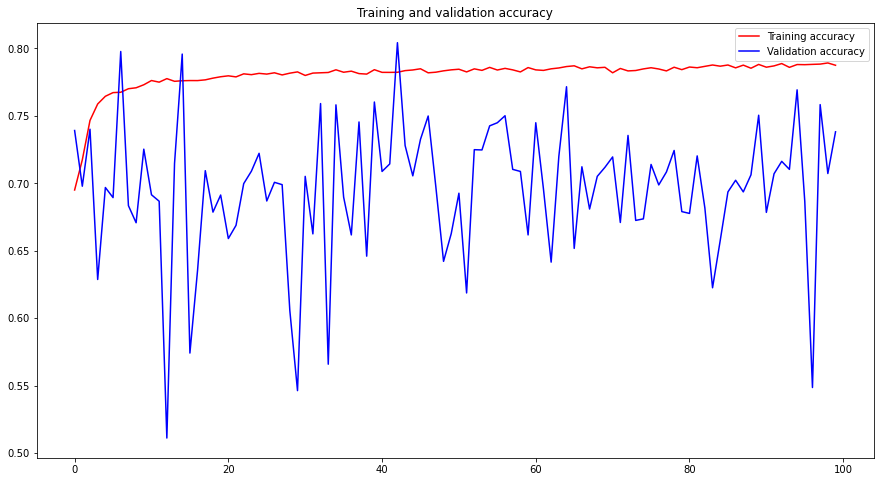

In [103]:
plot_accuracy(history_third)

In [104]:
third_attempt.evaluate(x_augmented_train, y_augmented_train, verbose=2)

1553/1553 - 1s - loss: 0.4104 - accuracy: 0.7937


[0.41040924191474915, 0.7936623096466064]

**Comment**: The accuracy obtained is lower than last time but the model seems to generalize better. We obtain an accuracy of `79.36%` when predictig the tennis matches outcome for the year of 2017

<a name='3-3-3'></a>
#### 3.3.3. Random forests

In this section I try random forests, which combines predictions from many different trees to create a robust classifier.

(**Note**: This section is more dedicated to the visualization of the predictions than to the model itself.)


In [119]:
random_forest=RandomForestClassifier(n_estimators=100, min_samples_leaf=20, max_depth=4, criterion='gini') 
random_forest.fit(x_augmented_train, y_augmented_train);
random_forest.score(x_augmented_test, y_augmented_test)

RandomForestClassifier(max_depth=4, min_samples_leaf=20)

0.6791301030141168

In this section I'll try to explain the predictions, using the [shap library](https://github.com/slundberg/shap)

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
> 
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see [Lundberg et al., 2019](https://arxiv.org/pdf/1802.03888.pdf).


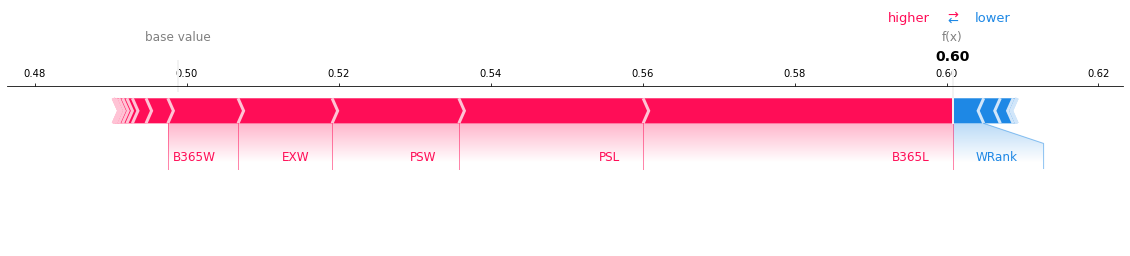

In [159]:
explainer = shap.TreeExplainer(random_forest)
i = 29
shap_value = explainer.shap_values(x_augmented_test.loc[x_augmented_test.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=x_augmented_test.columns, matplotlib=True)

The red sections on the left are features which push the model towards the final probability predicted for Player 1 to win in the positive direction (i.e. a higher odds value increases the probability of Player 1 to win).
The blue sections on the right are features that push the model towards the final prediction in the negative direction (A lower ATP ranking leads to a lower probability of winning)


We can also use SHAP values to understand the model output in aggregate:

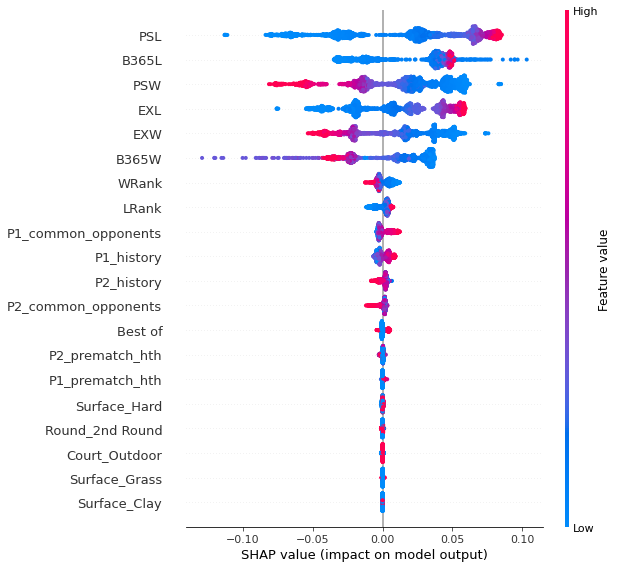

In [165]:
shap_values = shap.TreeExplainer(random_forest).shap_values(x_augmented_test)[1]
shap.summary_plot(shap_values, x_augmented_test)

We can see how features interact using dependence plots. These plot the SHAP value for a given feature for each data point, and color the points in using the value for another feature. This lets us begin to explain the variation in SHAP value for a single value of the main feature.

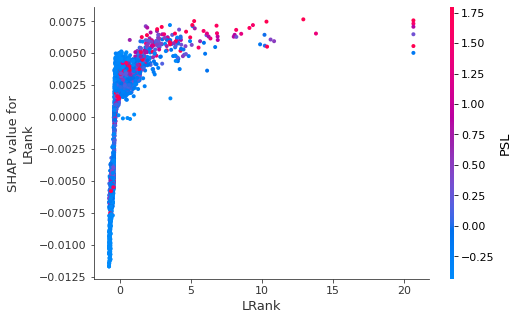

In [170]:
shap.dependence_plot('LRank', shap_values, x_augmented_test, interaction_index='PSL')

We see that when the rank of the player 2 (LRank) increases the odds increases for this player (PSL) and they decrease when his well ranked.

<a name='4'></a>
## 4. Conclusion

With the implemented neural network model we can correctly predict more events than the intuitive model which is based on the implicit information contained in the odds. which means that some events are mispriced i.e for these events the odds offered do not estimate their fair value.  If we slightly modify the model implemented so that it optimizes the return on investment when betting on a tennis match, we can deploy it in real life. However :

> Bookmakers, deploy a special set of practical rules to compensate
for these inefficiencies. A few weeks after we started trading with actual money some
bookmakers began to severely limit our accounts, forcing us to stop our betting strategy.
[Kaunitz et al., 2017](https://arxiv.org/ftp/arxiv/papers/1710/1710.02824.pdf)